<a href="https://colab.research.google.com/github/PabloPe4/LightGBM_Regression/blob/main/LightGBM_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Shap Values

In [43]:
!pip install shap #Install shap values for explainability

## Import Libraries

In [44]:
import pandas as pd
from pandas import read_csv
import numpy as np
from numpy import asarray
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import lightgbm as lgb
from matplotlib import pyplot
import shap

## Data Processing

In [45]:
# Load the dataset
path= '/content/Fish.csv'
delimiter = ','
df = read_csv(path, header='infer', index_col=0, delimiter=delimiter)
df.head()

,Weight,Length1,Length2,Length3,Height,Width
Species,,,,,,
Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [46]:
data = df.values #Transform the dataframe to an array

In [47]:
#Prepare the data
X, y = data[:, :-1], data[:, -1]
print(X.shape, y.shape)

#Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(159, 5) (159,)
(127, 5) (32, 5) (127,) (32,)


## LightGBM Model

Starting training...
[1]	valid_0's rmse: 0.566208
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.579393
[3]	valid_0's rmse: 0.52629
[4]	valid_0's rmse: 0.563604
[5]	valid_0's rmse: 0.558668
[6]	valid_0's rmse: 0.574804
[7]	valid_0's rmse: 0.541033
[8]	valid_0's rmse: 0.518284
[9]	valid_0's rmse: 0.536467
[10]	valid_0's rmse: 0.525321
[11]	valid_0's rmse: 0.515068
[12]	valid_0's rmse: 0.506571
[13]	valid_0's rmse: 0.521676
[14]	valid_0's rmse: 0.533475
[15]	valid_0's rmse: 0.523733
[16]	valid_0's rmse: 0.514208
[17]	valid_0's rmse: 0.515207
Early stopping, best iteration is:
[12]	valid_0's rmse: 0.506571
Saving model...
Starting predicting...


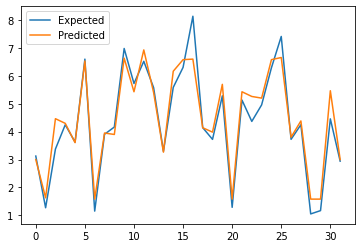

---------------------------------------------------------------
The rmse of prediction is: 0.2566143839026133
The R2 score of the prediction is: 0.9268671832672659
---------------------------------------------------------------


In [48]:
# Create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Specify params for model optimzation
params = {
    'boosting_type': 'rf',
    'objective': 'regression',
    'metric': 'rmse',
    'max_bin':50,
    'min_data_in_leaf':5,
    'num_leaves': 31,
    'max_depth': 8,
    'lambda': 0.1,
    'path_smooth': 1.325,
    'learning_rate': 0.09,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.6,
    'bagging_freq': 2,
    'verbose': 0
}

print('Starting training...')
# Train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('Saving model...')
# Save model to file
gbm.save_model('model.txt')

print('Starting predicting...')
# Predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)


# Plot
pyplot.plot(y_test, label='Expected')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

# Evaluate
print("---------------------------------------------------------------")
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred))
print('The R2 score of the prediction is:', r2_score(y_test, y_pred))
print("---------------------------------------------------------------")

## Grid Search

In [49]:
from sklearn.model_selection import GridSearchCV
estimator = lgb.LGBMRegressor()

In [63]:
# All parameters must be within square brackets (as a list)
params = {
    'boosting_type': ['rf'],
    'objective': ['regression'],
    'metric': ['rmse'],
    'max_bin':[50],
    'min_data_in_leaf':[5,7],
    'num_leaves': [31],
    'max_depth': [8],
    'lambda': [0.1],
    'path_smooth': [1.25],
    'learning_rate': [0.01,0.05,0.09],
    'feature_fraction': [0.5,0.6,0.7],
    'bagging_fraction': [0.6,0.7],
    'bagging_freq': [2],
    'verbose': [0]
}

In [64]:
# Grid Search to find the best parameters
gbm = GridSearchCV(estimator, params)
gbm.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=T...
             param_grid={'bagging_fraction': [0.6, 0.7], 'bagging_freq': [2],
                         'boosting_type': ['rf'],
                         'feature_fraction': [0.5, 0.6, 0.7], 'lambda': [0.1],
                         'learning_rate': [0.01, 0.05, 0.09], 'max_bin': [50],
                         'max_depth': [8], 'metric': ['rmse'],
       

In [65]:
# List best params
best_params = {}
best_params = gbm.best_params_
print('------------------------------------------------------------')
print('Best parameters found by grid search are:', gbm.best_params_)

------------------------------------------------------------
Best parameters found by grid search are: {'bagging_fraction': 0.7, 'bagging_freq': 2, 'boosting_type': 'rf', 'feature_fraction': 0.6, 'lambda': 0.1, 'learning_rate': 0.01, 'max_bin': 50, 'max_depth': 8, 'metric': 'rmse', 'min_data_in_leaf': 5, 'num_leaves': 31, 'objective': 'regression', 'path_smooth': 1.25, 'verbose': 0}


## Re-train Model with Best Parameters

Starting training...
[1]	valid_0's rmse: 0.555642
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's rmse: 0.558771
[3]	valid_0's rmse: 0.479909
[4]	valid_0's rmse: 0.462102
[5]	valid_0's rmse: 0.458244
[6]	valid_0's rmse: 0.465195
[7]	valid_0's rmse: 0.45145
[8]	valid_0's rmse: 0.455275
[9]	valid_0's rmse: 0.445044
[10]	valid_0's rmse: 0.440649
[11]	valid_0's rmse: 0.461138
[12]	valid_0's rmse: 0.450931
[13]	valid_0's rmse: 0.449641
[14]	valid_0's rmse: 0.454725
[15]	valid_0's rmse: 0.452393
Early stopping, best iteration is:
[10]	valid_0's rmse: 0.440649
Saving model...
Starting predicting...


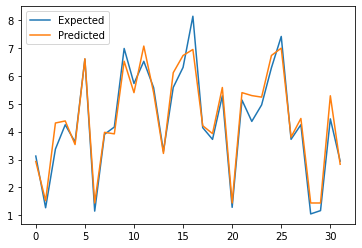

---------------------------------------------------------------
The rmse of prediction is: 0.19417114792266119
The R2 score of the prediction is: 0.9446629500659571
---------------------------------------------------------------


In [66]:
print('Starting training...')
# Train
gbm = lgb.train(best_params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('Saving model...')
# Save model to file
gbm.save_model('model.txt')

print('Starting predicting...')
# Predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)


# Plot
pyplot.plot(y_test, label='Expected')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

# Evaluate
print("---------------------------------------------------------------")
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred))
print('The R2 score of the prediction is:', r2_score(y_test, y_pred))
print("---------------------------------------------------------------")

## Shap Values

In [67]:
# Strat timer and instantiate the tree explainer
%time shap_values = shap.TreeExplainer(gbm).shap_values(X_test)

CPU times: user 9.82 ms, sys: 883 µs, total: 10.7 ms
Wall time: 15.5 ms


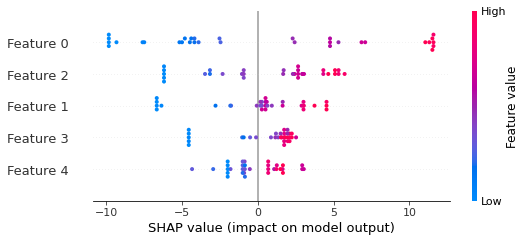

In [68]:
# Plot shap values (i.e. feature impact)
shap.summary_plot(shap_values, X_test)